# EDA - Exploratory Data Analysis
This notebook just for Descriptive Analysis to make inference about the dataset ES_0 (collected info from cimate station A612). 
With those inferences we will proceed to make our first models.

<a href="https://ibb.co/ZccxLYV"><img src="https://i.ibb.co/KVVW0LX/A612-Station.png" alt="A612-Station" border="0"></a>  
lat -20.2666, long -40.3

#### Objectives from this notebook:
1. understand the data
    1. define Y - Target variables (min max temperature and rain)
    1. descriptive
    2. understand basic sazonalities
    1. understand relations between variables
    2. check for outliers
2. Understand autoregressive structures
    1. Make linear models using non stocastic variables
    2. ACF and PACF from linear regression errors
    3. Check for sazonalities in errors

### Proposal notebook structure:
1. Imports and adding non-stocastic covariables
<!-- 2. Descriptive about the dataframe -->
2. Y - Targets variables descriptive
    1. year, month and day Boxplots
    2. Lineplot with min and max temperatures
    3. histogram plot with rain
3. X
    1. Histogram
    2. Lineplots
    4. Crosstable just with target variables
4. Errors from Linear Regression
    1. First model: OLS with non-stocastic variables (month dummies and transformed hour)
    2. Analyse the errors from the linear model
    3. Acf and pacf from errors
    4. Erros sazonality

### Importing Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
sns.set()

figsize = (20,7)
figsize2 = (20,5)

import os
directory = '../input/hourly-weather-surface-brazil-southeast-region/'
os.chdir(directory)
import make_dataset as mk

### Reading data
Dataset 0 has 46 columns, for the Exploratory Data Analysis we just need the Index and the Maximum Temperature from Station A612.  
All other columns are dummies just needed to make the autoregressive models. To get the month and year information we will use methods from Pandas

In [2]:
df_raw = pd.read_csv('southeast.csv')

stations = ['A612']
start_date = '2006-11-01'
df = mk.make_dataset(stations, start_date, df_raw)
df_raw = None

In [3]:
## adding covariables
df.date_time = pd.to_datetime(df.date_time)
df['hour'] = df.date_time.dt.hour
df['month'] = df.date_time.dt.month
df['year'] = df.date_time.dt.year
df['day_of_year'] = df.date_time.dt.day_of_year
df['weekofyear'] = df.date_time.dt.weekofyear

## transforming start hour in 9, to use hour**3, some models are hierarchical so is necessary to keep hour**2 
df['hour_9'] = df['hour'].apply(lambda x: (x-9)%24)
df['hour_9**2'] = df['hour_9']**2
df['hour_9**3'] = df['hour_9']**3

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [4]:
# setting target variables to be easy to call later
y1,y2,y3 = 'A612_prcp','A612_tmax','A612_tmin'# 'A612 - total precipitation (mm)' "max temp" "min temp"

---
## 2. Y - Target variables descriptive analysis

In [5]:
def two_line_plot(df, x1, x2, freq = 'M', figsize = (20,5), tittle = ''):
    temp = df[['date_time',x1,x2]]
    temp.index = temp.date_time
    temp = temp.resample(freq).mean()
    temp.reset_index(inplace=True)
    plt.figure(figsize = figsize)
    _ = sns.lineplot(x = temp['date_time'],y = temp[x1]).set_title(tittle,fontsize=20)
    _ = sns.lineplot(x = temp['date_time'],y = temp[x2])
    
def two_hist_plot(df, x1, x2, freq = 'M', figsize = figsize2, tittle = ''):
    temp = df[['date_time',x1,x2]]
    temp.index = temp.date_time
    temp = temp.resample(freq).mean()
    temp.reset_index(inplace=True)
    plt.figure(figsize = figsize)
    _ = sns.histplot(df[x1],color = 'red').set_title(tittle,fontsize=20)
    _ = sns.histplot(df[x2]) 

def one_line_plot(df, x1, freq = 'M', figsize = figsize2, tittle = ''):
    temp = df[['date_time',x1]]
    temp.index = temp.date_time
    temp = temp.resample(freq).mean()
    temp.reset_index(inplace=True)
    plt.figure(figsize = figsize)
    _ = sns.lineplot(x = temp['date_time'],y = temp[x1]).set_title(tittle,fontsize=20)

def one_hist_plot(df, x1, freq = 'M', figsize = figsize2, tittle = ''):
    temp = df[['date_time',x1]]
    temp.index = temp.date_time
    temp = temp.resample(freq).mean()
    temp.reset_index(inplace=True)
    plt.figure(figsize = figsize)
    _ = sns.histplot(df[x1],color = 'red').set_title(tittle,fontsize=20)

## Min Max temperature

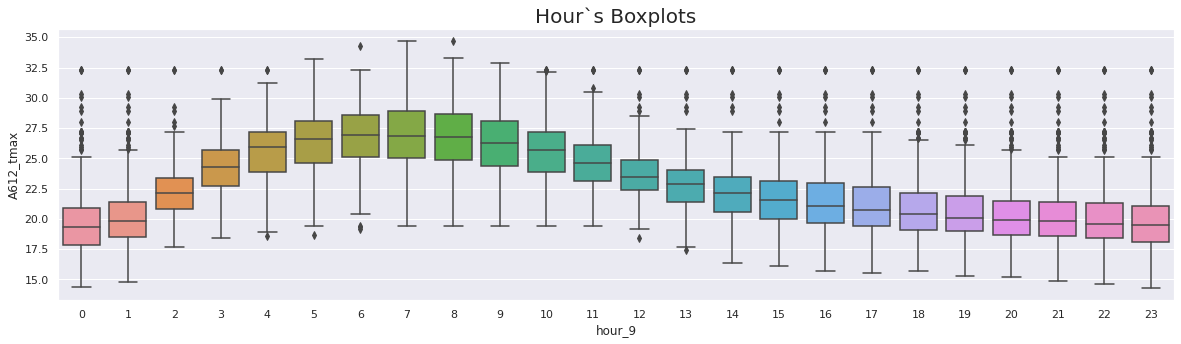

In [6]:
plt.figure(figsize=figsize2)
tittle = 'Hour`s Boxplots'
_ = sns.boxplot(data=df[df.month == 6],y = y2, x='hour_9').set_title(tittle,fontsize=20)

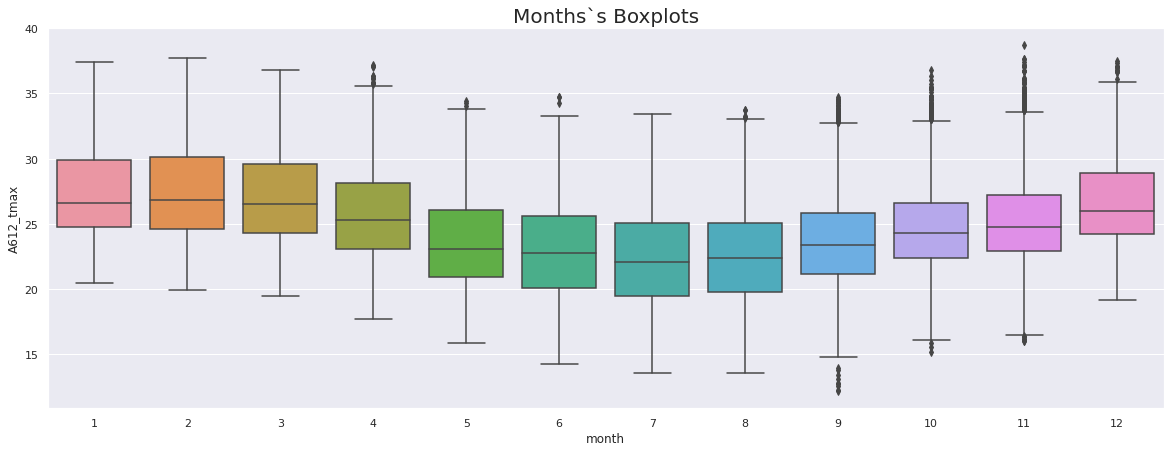

In [7]:
# change y for y1 and y2 to se other results
plt.figure(figsize=figsize)
tittle = 'Months`s Boxplots'
_ = sns.boxplot(data=df,y = y2, x='month').set_title(tittle,fontsize=20)

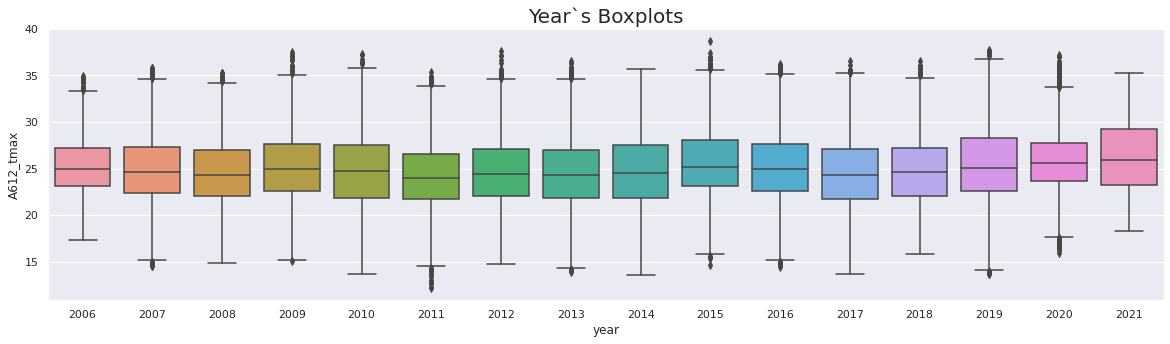

In [8]:
plt.figure(figsize=figsize2)
tittle = 'Year`s Boxplots'
_ = sns.boxplot(data=df,y = y2, x='year').set_title(tittle,fontsize=20)

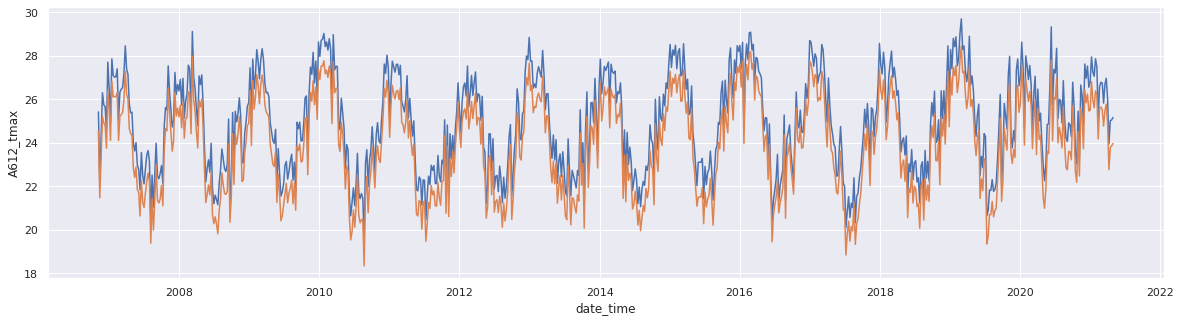

In [9]:
two_line_plot(df,y2,y3,freq='W')

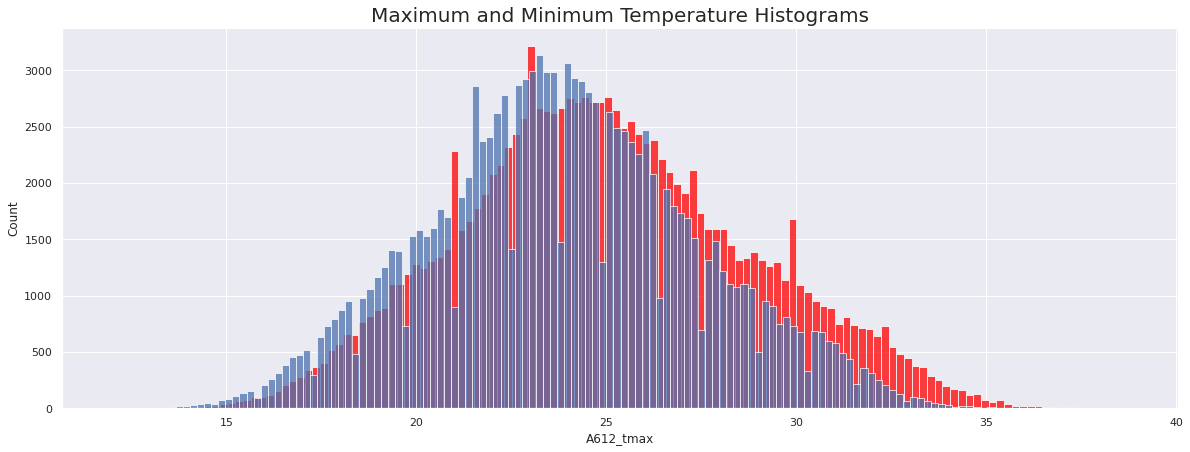

In [10]:
plt.figure(figsize=figsize)
tittle = 'Maximum and Minimum Temperature Histograms'
_ = sns.histplot(df[y2],color = 'red').set_title(tittle,fontsize=20)
_ = sns.histplot(df[y3])
## plot have these holes because we just have one number after the .

---
## Rain

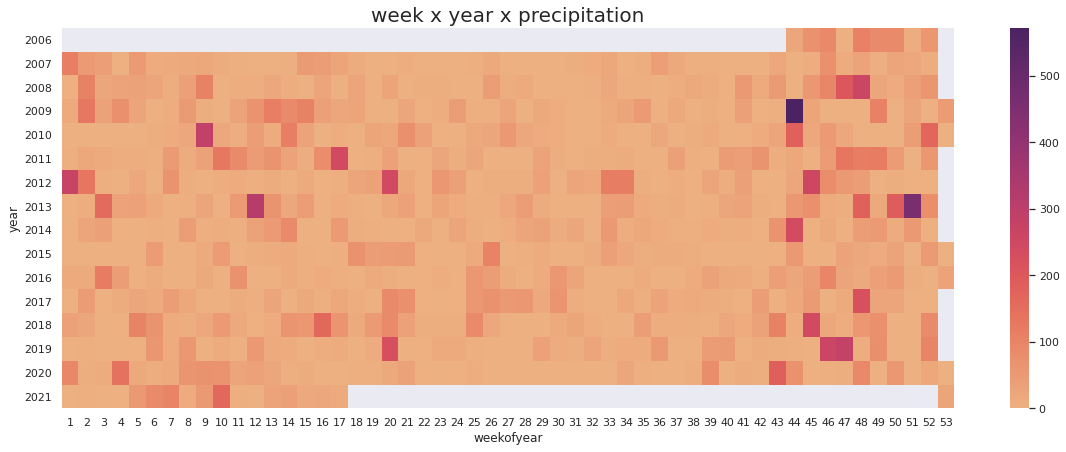

In [11]:
tittle = 'week x year x precipitation'
plt.figure(figsize = figsize)
temp = df[['weekofyear','year',y1]]
temp = temp.groupby(['year','weekofyear']).sum()
temp.reset_index(inplace=True)
temp = temp.pivot(index='year',columns='weekofyear',values=y1)
_ = sns.heatmap(temp,cmap="flare").set_title(tittle,fontsize=20)
## in summer we have more rain

Text(0.5, 1.0, 'week x year x precipitation')

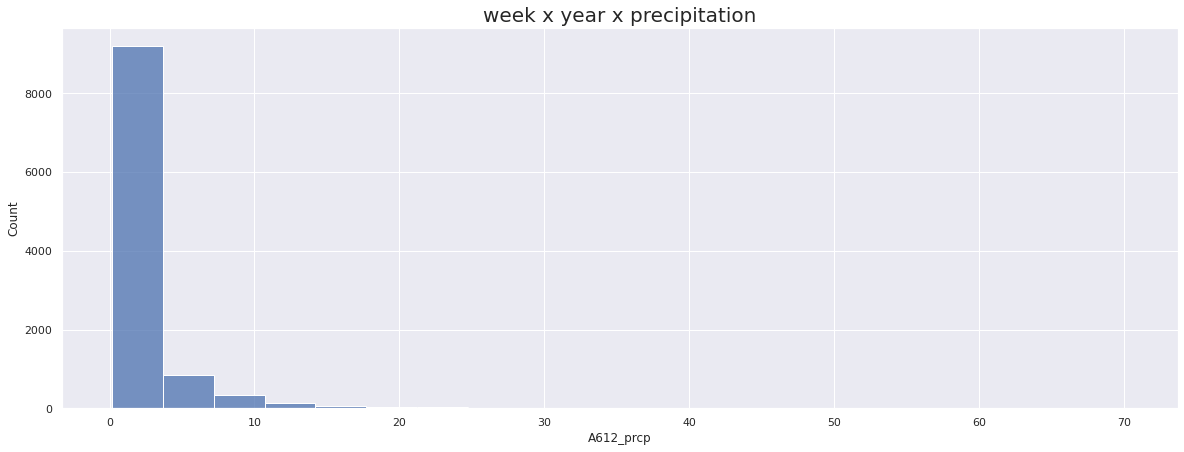

In [12]:
tittle = 'week x year x precipitation'
plt.figure(figsize = figsize)
sns.histplot(df[df[y1]>0][y1],bins=20).set_title(tittle,fontsize=20)
## dont rain most of the days thats why we see the zeros

---
## 3. X - Covariables
If you want to change a variable to see the graph copy from df.columns output and paste in x1 or x2 variables

#### Min max variables
1. atmospheric pressure min max
2. temperatura orvalho min e max
3. humidity min e max

#### Single variables
1. air temperature - bulbo seco
2. air temperature - dew
3. wind direction
4. wind max gust
5. wind speed
6. radiation

In [13]:
df.columns

Index(['date_time', 'A612_prcp', 'A612_stp', 'A612_smax', 'A612_smin',
       'A612_temp', 'A612_dewp', 'A612_tmax', 'A612_tmin', 'A612_dmax',
       'A612_dmin', 'A612_hmax', 'A612_hmin', 'A612_hmdy', 'A612_wdct',
       'A612_gust', 'A612_wdsp', 'hour', 'month', 'year', 'day_of_year',
       'weekofyear', 'hour_9', 'hour_9**2', 'hour_9**3'],
      dtype='object')

<Figure size 1440x504 with 0 Axes>

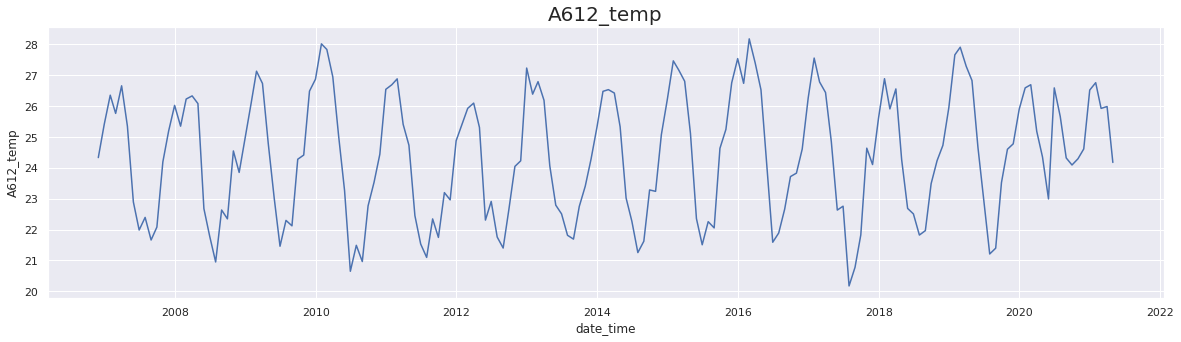

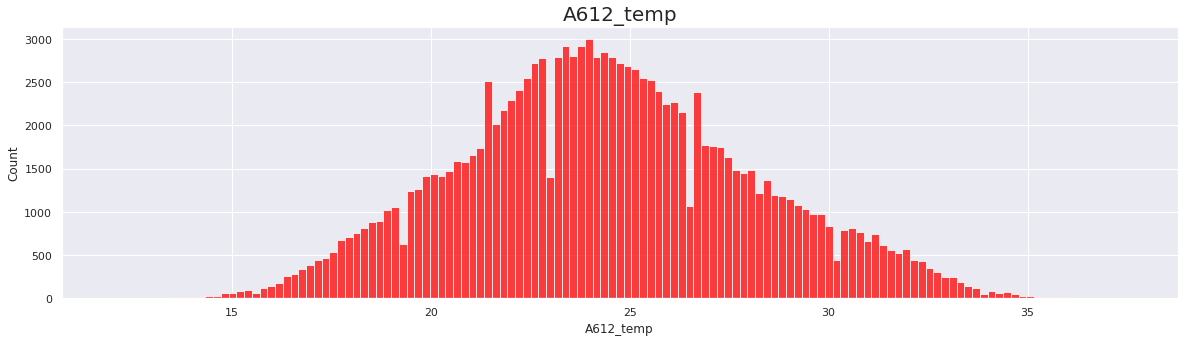

In [14]:
x1 = 'A612_temp'#'A612 - air temperature - dry bulb (°c)'
tittle = x1
plt.figure(figsize=figsize)
one_line_plot(df,x1 = x1, freq='M', tittle = tittle)
one_hist_plot(df,x1 = x1, freq='M', tittle = tittle)

In [15]:
pd.read_csv('columns_description.csv')

column_index                                     columns_pt-br  \
0              0                                              data   
1              1                                              hora   
2              2                   precipitacao total,horario (mm)   
3              3      pressao atmosferica ao nivel da estacao (mb)   
4              4  pressao atmosferica max. na hora ant. (aut) (mb)   
5              5  pressao atmosferica min. na hora ant. (aut) (mb)   
6              6                                 radiation (kj/m2)   
7              7               temperatura do ar - bulbo seco (°c)   
8              8              temperatura do ponto de orvalho (°c)   
9              9        temperatura maxima na hora ant. (aut) (°c)   
10            10        temperatura minima na hora ant. (aut) (°c)   
11            11  temperatura orvalho max. na hora ant. (aut) (°c)   
12            12  temperatura orvalho min. na hora ant. (aut) (°c)   
13            13          umidade rel. max. na hora ant. (aut) (%)   
14            14          umidade rel. min. na hora ant. (aut) (%)   
15            15               umidade relativa do ar, horaria (%)   
16            16               vento direcao horaria (gr) (° (gr))   
17            17                         vento rajada maxima (m/s)   
18            18                    vento velocidade horaria (m/s)   
19            19                                            region   
20            20                                             state   
21            21                                           station   
22            22                                      station_code   
23            23                                          latitude   
24            24                                         longitude   
25            25                                            height   

                                           columns_en abbreviation  \
0                                                date         date   
1                                                hour           hr   
2                            total precipitation (mm)         prcp   
3         atmospheric pressure at station height (mb)          stp   
4   atmospheric pressure max. in the previous hour...         smax   
5   atmospheric pressure min. in the previous hour...         smin   
6                                   radiation (kj/m2)         gbrd   
7                     air temperature - dry bulb (°c)         temp   
8                          dew point temperature (°c)         dewp   
9          max. temperature in the previous hour (°c)         tmax   
10         min. temperature in the previous hour (°c)         tmin   
11     dew temperature max. in the previous hour (°c)         dmax   
12     dew temperature min. in the previous hour (°c)         dmin   
13    relative humidity max. in the previous hour (%)         hmax   
14    relative humidity min. in the previous hour (%)         hmin   
15                          air relative humidity (%)         hmdy   
16                            wind direction (° (gr))         wdct   
17                           wind rajada maxima (m/s)         gust   
18                                   wind speed (m/s)         wdsp   
19                                             region          NaN   
20                                              state         prov   
21                                            station         wsnm   
22                                       station_code         inme   
23                                           latitude          lat   
24                                          longitude          lon   
25                                             height         elvt   

                                          description  
0                                   date (YYYY-MM-DD)  
1                                        hour (HH:00)  
2   Amount of precipitation in millimetres (last h... 

<Figure size 1440x504 with 0 Axes>

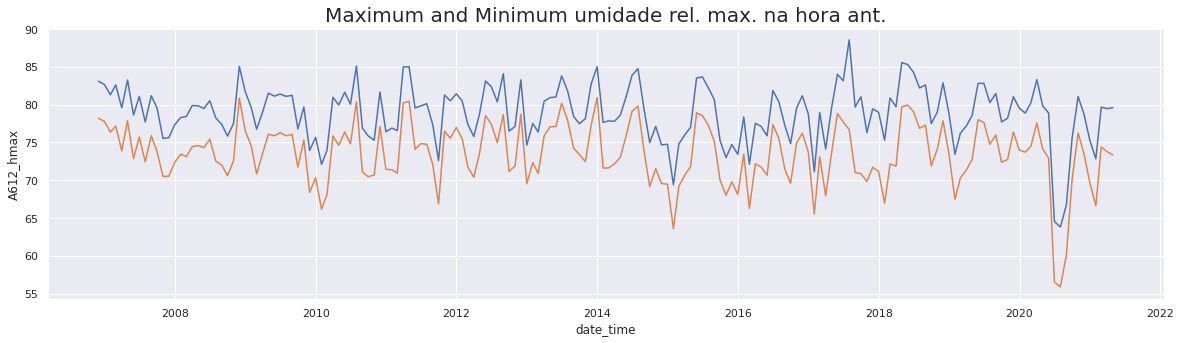

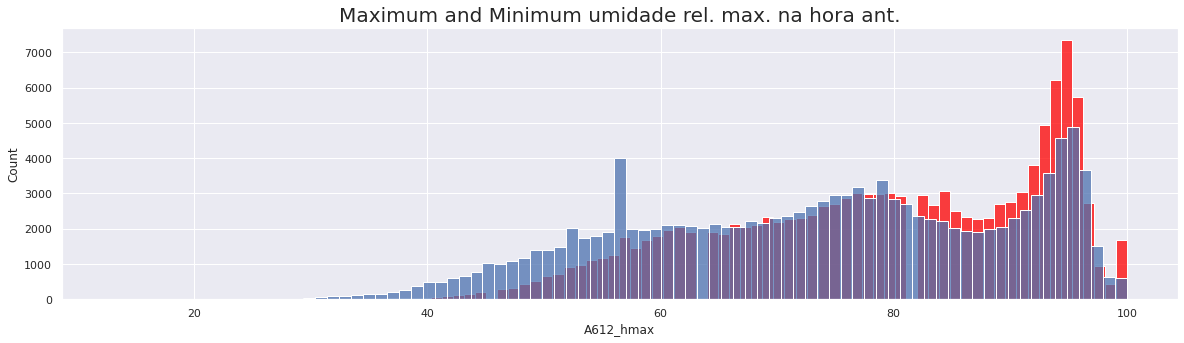

In [16]:
x1 = 'A612_hmax'#'A612 - relative humidity max. in the previous hour (%)'
x2 = 'A612_hmin'#'A612 - relative humidity min. in the previous hour (%)'
tittle = 'Maximum and Minimum umidade rel. max. na hora ant.'
plt.figure(figsize=figsize)
two_line_plot(df,x1 = x1,x2 =x2 ,freq='M', tittle = tittle)
two_hist_plot(df,x1 = x1,x2 =x2 ,freq='M', tittle = tittle)

<AxesSubplot:>

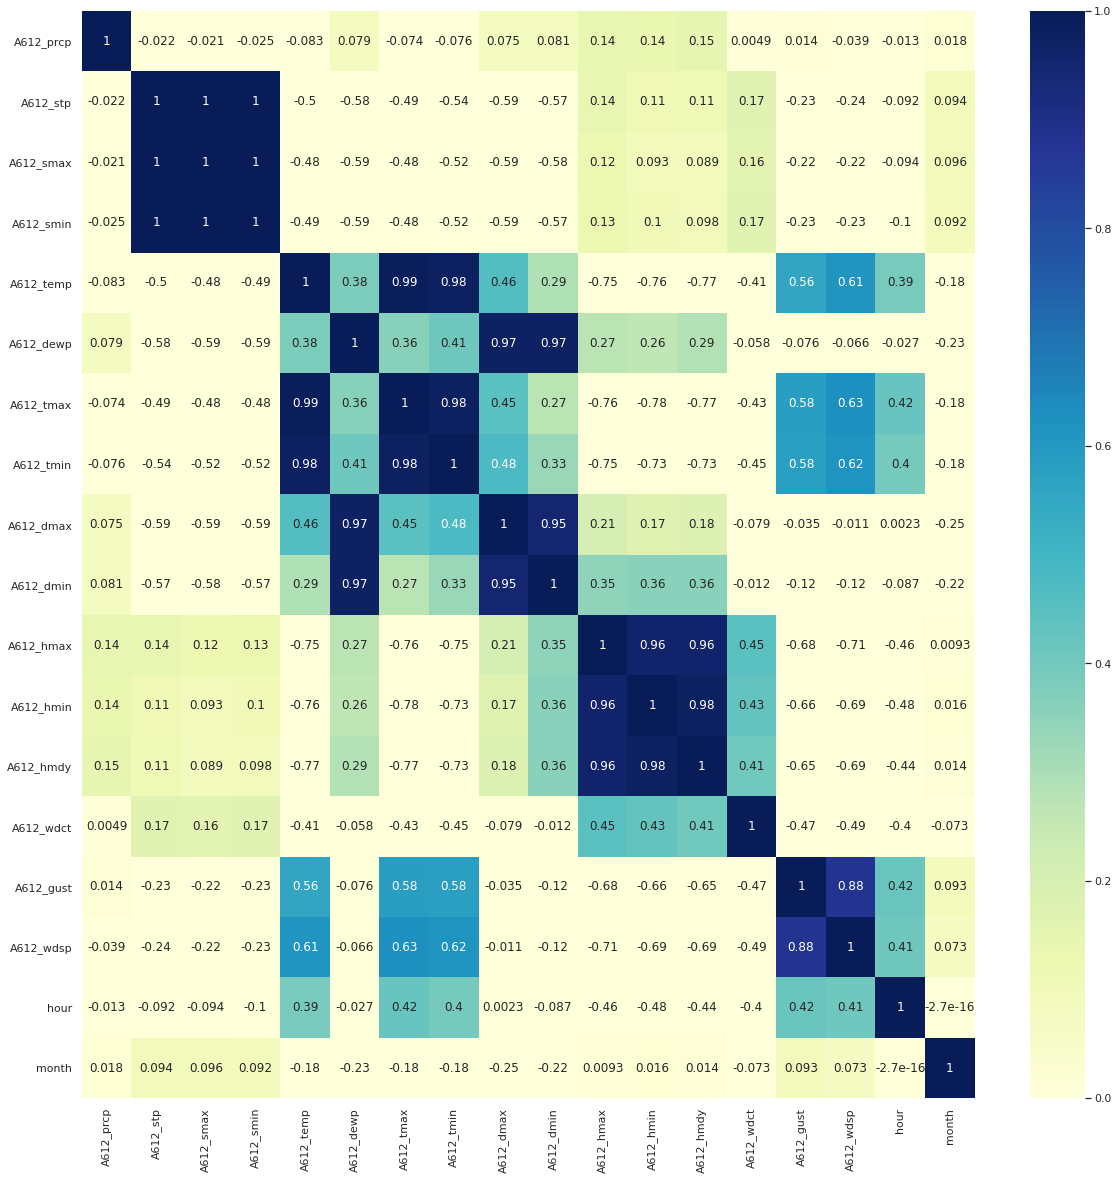

In [17]:
plt.figure(figsize = (20,20))
sns.heatmap(df.iloc[:,1:-6].corr(),cmap="YlGnBu",vmin=0,annot=True)
# can see that will be necessary select the variables because of multicolinearity, or a PCA or a "AR PCA"

<Figure size 1440x1440 with 0 Axes>

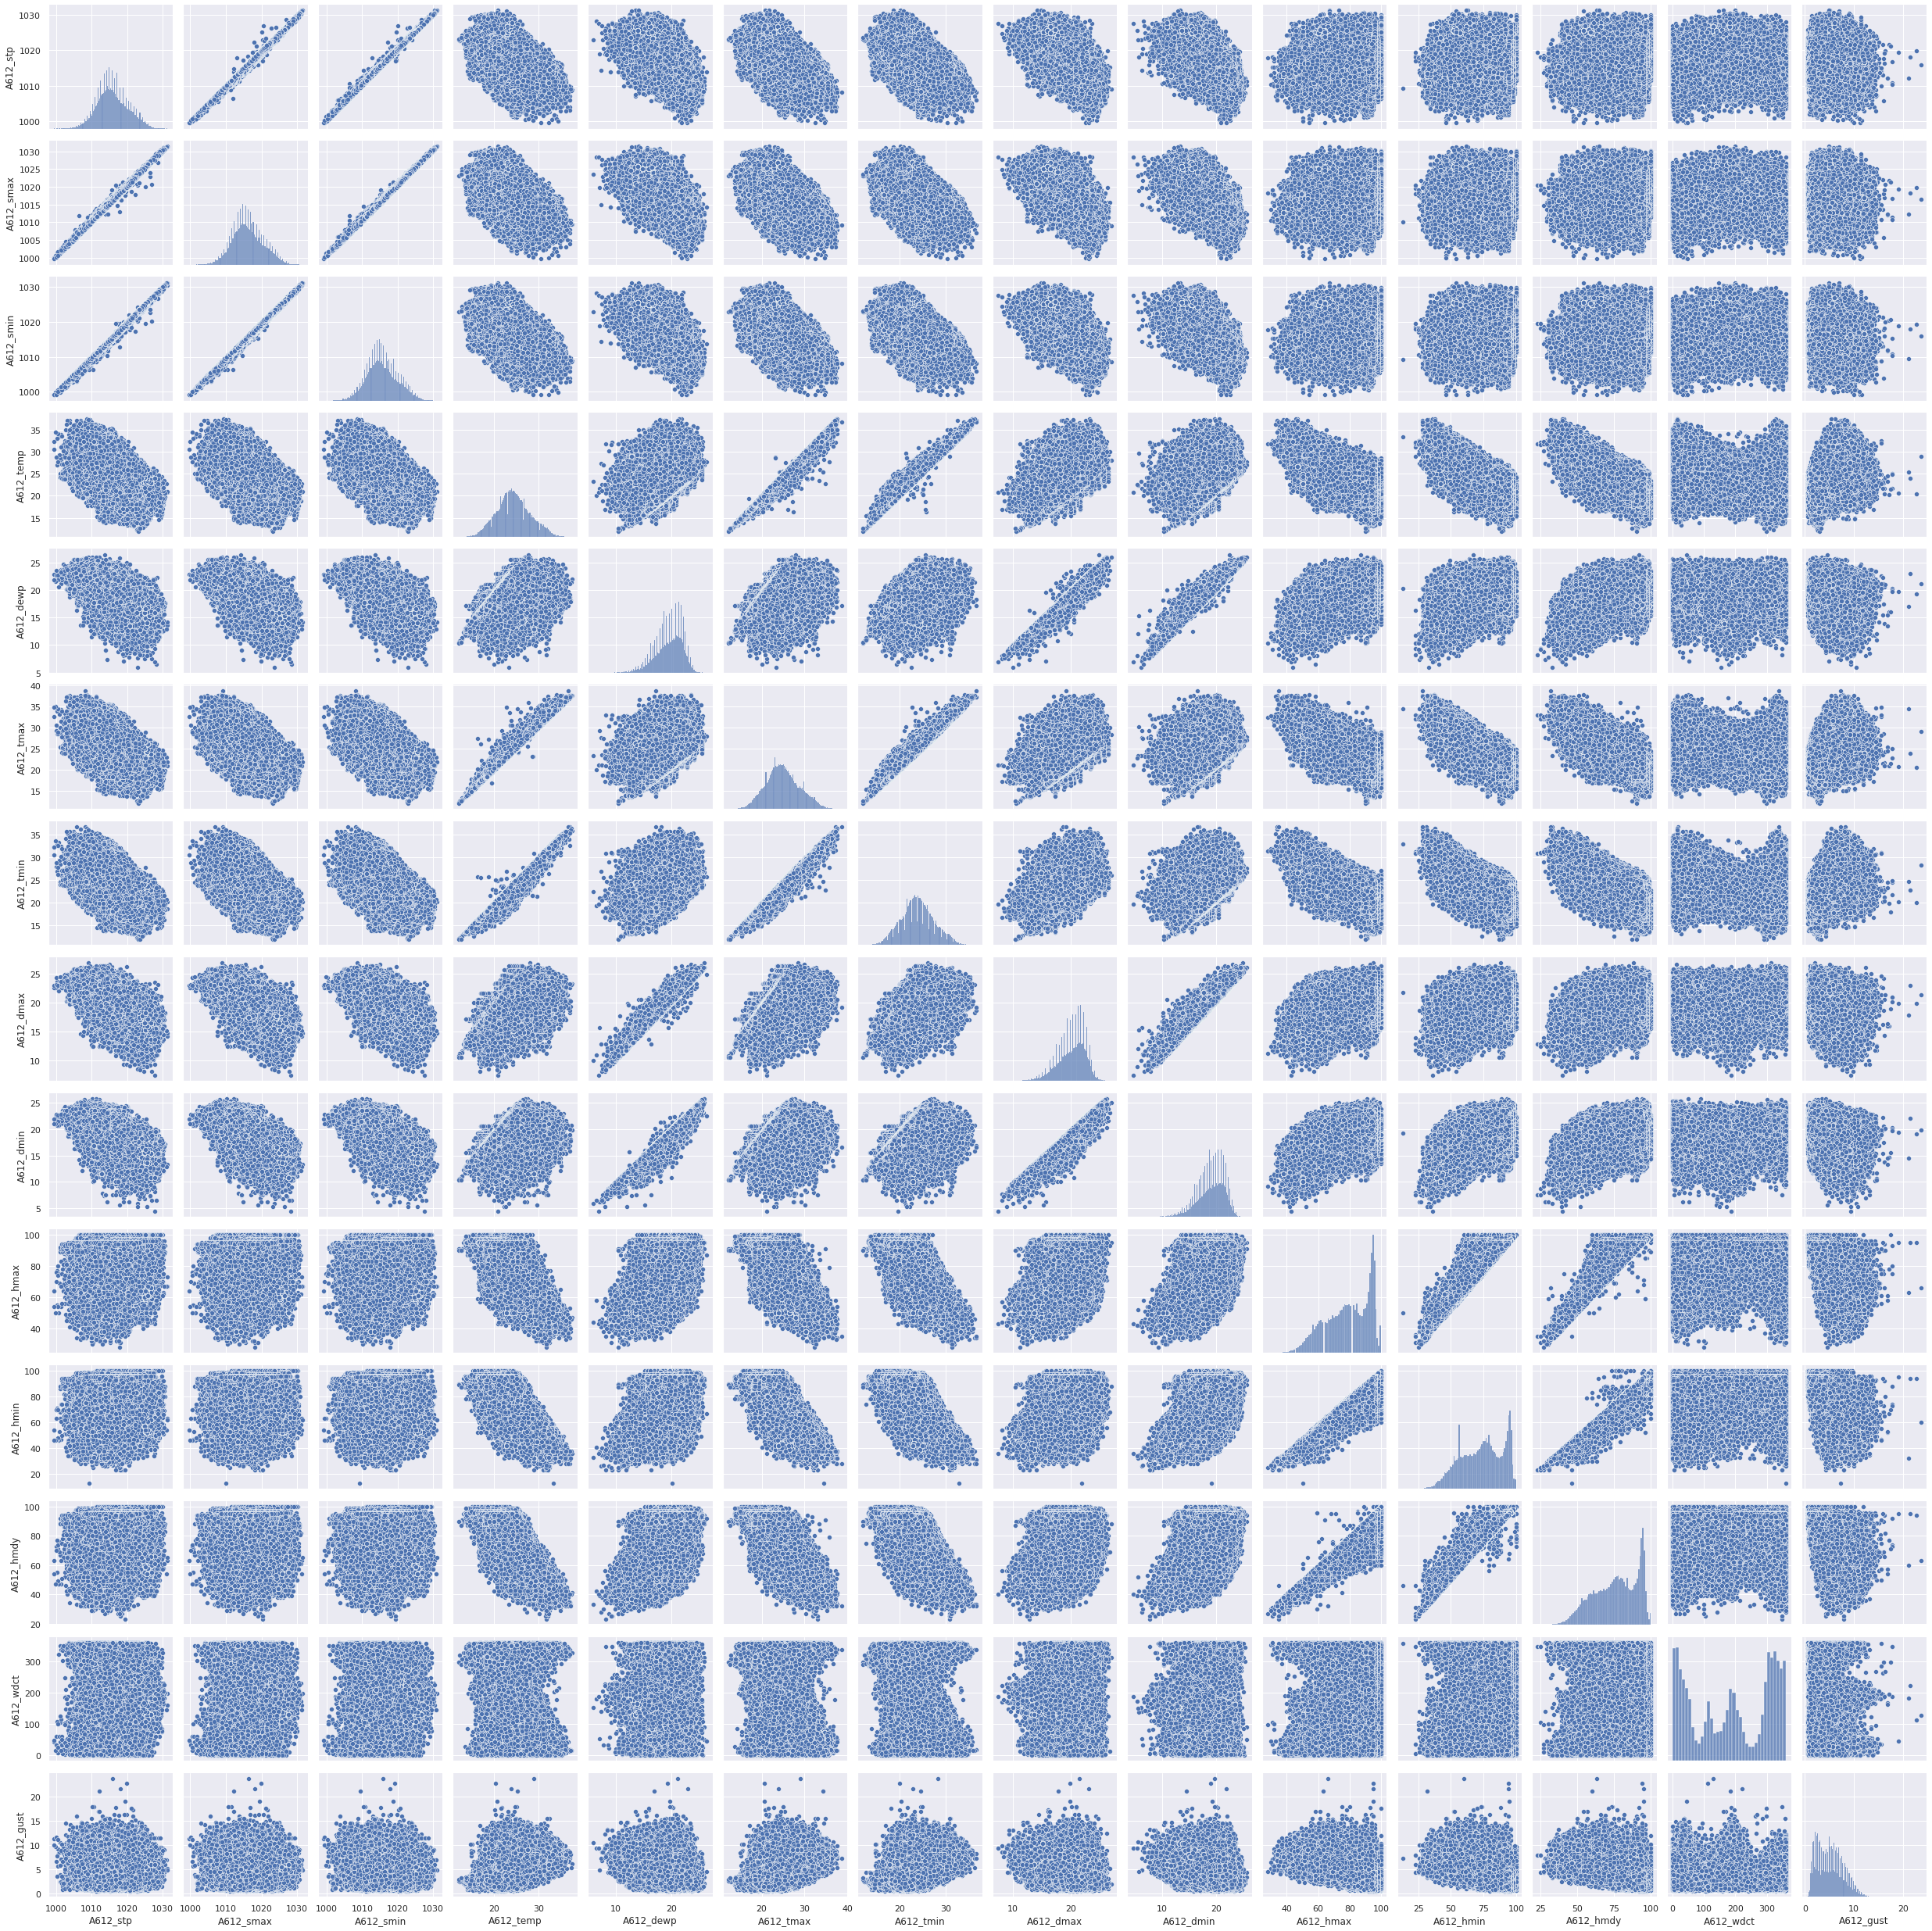

In [18]:
plt.figure(figsize = (20, 20)) 
_ = sns.pairplot(df.iloc[:,2:-9])
# we can see the multicolinearity again

---
## 4.  Errors from Linear Regression

In [19]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from metrics import create_metrics

In [20]:
def make_dummies(series):
    df = pd.get_dummies(series,drop_first=True)
    df.columns = list(map(lambda x: '{}_'.format(series.name) + str(x),list(df.columns)))
    return df

In [21]:
def ols_model(x, y, codename=None):
    if codename == None:
        codename = f'{x.shape[1]}_{y.name.split("_")[1]}'
        
    x_train, x_test = x[df_model.date_time<'01-01-2018'], x[df_model.date_time>='01-01-2018']
    y_train, y_test = y[df_model.date_time<'01-01-2018'], y[df_model.date_time>='01-01-2018']
    
    model = OLS(y_train,x_train)
    fit = model.fit()
    y_pred = fit.predict(x_test)
    
    metrics = create_metrics(y_test,y_pred)
    return {'y_pred': y_pred, 'fit': fit, 'model':model, 'metrics':metrics, 'codename': codename}


In [22]:
df_model = df[df.date_time < '01-01-2020']

In [23]:
_y_ = df_model[[y1,y2,y3]]
x = df_model.iloc[:,-7:]
x['hour'] = df_model.hour
x = x.drop(['day_of_year','weekofyear','year'],axis=1)

In [24]:
x = pd.concat([x,make_dummies(x['month'])],axis=1)
x.drop(['month', 'hour'],axis=1,inplace=True)
x['intercept'] = 1

In [25]:
model = ols_model(x,_y_.iloc[:,1])

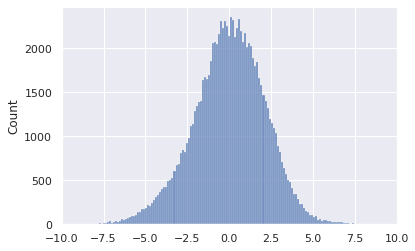

In [26]:
residuals = model['fit'].resid
plt.xlim(-10,10)
_ = sns.histplot(residuals)

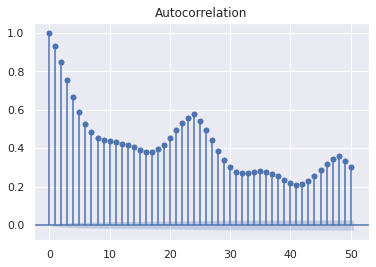

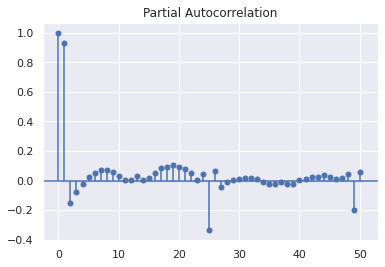

In [27]:
_ = plot_acf(residuals)
_ = plot_pacf(residuals)

In [28]:
df_plot = pd.DataFrame(df_model.date_time[:len(residuals)])
df_plot['resid'] = residuals
df_plot.index = df_plot.date_time
df_plot.drop('date_time',inplace=True,axis=1)
df_plot = df_plot.resample('M').mean()

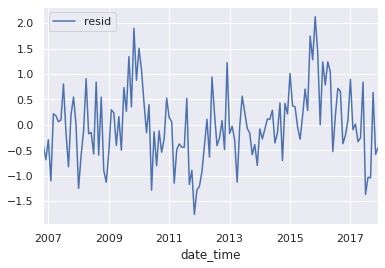

In [29]:
_ = df_plot.plot()

## Conclusions
#### EDA:
1. year sazonality
2. hour transformation
3. multicolinarity
4. 2020 unregular year
5. outliers (possibles errors) created by cleanning NAs(will be replaced in the future)

#### Ordinary Least Squares
1. Errors look like are normal (not tested)
2. Autoregressive information in the regression residuals

metric|value
---|---
mean abs deviation| 2.907495302172599
mean absolute error| 1.6822048040370292
median abs deviation| 2.400000000000002
median absolute error| 1.398029803702002

The OLS model have a decent fit with just non-stocastic covariables, but we still have information in the data that we will try to explained using autoregressive information and adding extra covariables.